In [205]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

import math
import pandas as pd
import numpy as np


# import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
# device = torch.device("cuda" if torch.version.hip else "cpu")
# print(device)
df = pd.read_excel("forecast_data20242-025.xlsx", header=2)
df.head()

,TrnYear,TrnMonth,Register,Invoice,SummaryLine,DetailLine,InvoiceDate,Branch,Cust #,Customer Name,...,GlYear,GlPeriod,SalesOrder,ContractPrcNum,LineInvoiceDisc,PostCurrency,SalesOrderLine,StockUom,Colour,Container
0,2024,1,2,21165,1,1,2023-07-04,LD,L001,L001 - SA,...,2024,1,20044,202306-GENV1,0.0,R,1,EA,Magenta,Bottle 5L
1,2024,1,3,21166,1,1,2023-07-05,LD,E001,E001 - SA,...,2024,1,19998,202306-GENV1,0.0,R,1,EA,Cyan,Pouch 2000ml
2,2024,1,3,21166,1,2,2023-07-05,LD,E001,E001 - SA,...,2024,1,19998,202306-GENV1,0.0,R,2,EA,Magenta,Pouch 2000ml
3,2024,1,3,21166,1,3,2023-07-05,LD,E001,E001 - SA,...,2024,1,19998,202306-GENV1,0.0,R,3,EA,Yellow,Pouch 2000ml
4,2024,1,3,21166,1,4,2023-07-05,LD,E001,E001 - SA,...,2024,1,19998,202306-GENV1,0.0,R,4,EA,Clear,Bottle 2L


In [3]:
print(df.columns)
print(df.dtypes)


Index(['TrnYear', 'TrnMonth', 'Register', 'Invoice', 'SummaryLine',
       'DetailLine', 'InvoiceDate', 'Branch', 'Cust #', 'Customer Name',
       'Area', 'Region2', 'SKU', 'SKU Description', 'Warehouse', 'QtyInvoiced',
       'Mass', 'Volume', 'Unit', 'NetSalesValue', 'TaxValue', 'DiscValue',
       'LineType', 'PriceCode', 'DocumentType', 'GlYear', 'GlPeriod',
       'SalesOrder', 'ContractPrcNum', 'LineInvoiceDisc', 'PostCurrency',
       'SalesOrderLine', 'StockUom', 'Colour', 'Container'],
      dtype='object')
TrnYear                     int64
TrnMonth                    int64
Register                    int64
Invoice                     int64
SummaryLine                 int64
DetailLine                  int64
InvoiceDate        datetime64[ns]
Branch                     object
Cust #                     object
Customer Name              object
Area                       object
Region2                    object
SKU                         int64
SKU Description            object
W

In [4]:
print(df.shape)

(21565, 35)


### DATA preprocessing

In [5]:
#easier column classification
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.rename( columns= {"InvoiceDate": "date" ,
                          "Customer Name": "cust_id",
                          "QtyInvoiced": "qty",
                          "Unit": "price",
                          "SKU": "item",
                          "Region2": "region",
                          "Colour": "color",
                          "Container": "container",
                          "NetSalesValue": "netsales",
                          "PostCurrency": "currency",
                         
                         })

#ensure ints and categories are category
df['item'] = df['item'].astype("category")
df['region'] = df['region'].astype("category")
df['cust_id'] = df['cust_id'].astype("category")
df["color_container"] = (df['color'] + "_" + df["container"]).astype("category")
df['color'] = df['color'].astype("category")
df['container'] = df['container'].astype("category")
df['currency'] = df['currency'].astype("category")
df = df.sort_values(by=["cust_id", "item", "date"])



In [6]:
df.columns

Index(['TrnYear', 'TrnMonth', 'Register', 'Invoice', 'SummaryLine',
       'DetailLine', 'date', 'Branch', 'Cust #', 'cust_id', 'Area', 'region',
       'item', 'SKU Description', 'Warehouse', 'qty', 'Mass', 'Volume',
       'price', 'netsales', 'TaxValue', 'DiscValue', 'LineType', 'PriceCode',
       'DocumentType', 'GlYear', 'GlPeriod', 'SalesOrder', 'ContractPrcNum',
       'LineInvoiceDisc', 'currency', 'SalesOrderLine', 'StockUom', 'color',
       'container', 'color_container'],
      dtype='object')

In [7]:
df = df.drop(['TrnYear', 'TrnMonth', 'Register', 'Invoice', 'SummaryLine',
       'DetailLine',  'Branch', 'Cust #', 'Area',
     'SKU Description', 'Warehouse', 'Mass',
       'Volume',  'TaxValue', 'DiscValue', 'LineType',
       'PriceCode', 'DocumentType', 'GlYear', 'GlPeriod', 'SalesOrder',
       'ContractPrcNum', 'LineInvoiceDisc', 'SalesOrderLine',
       'StockUom'], axis=1)

In [8]:

print(df["color_container"].nunique())
print(df["item"].nunique())

133
1177


In [9]:
df.dtypes

date               datetime64[ns]
cust_id                  category
region                   category
item                     category
qty                         int64
price                       int64
netsales                    int64
currency                 category
color                    category
container                category
color_container          category
dtype: object

In [10]:
df.head()

,date,cust_id,region,item,qty,price,netsales,currency,color,container,color_container
8338,2024-04-10,A001 - AP,AUSTRALIA,4750522,12,500,6000,USD,Cyan,Bottle 1L,Cyan_Bottle 1L
8339,2024-04-10,A001 - AP,AUSTRALIA,4750523,6,500,3000,USD,Magenta,Bottle 1L,Magenta_Bottle 1L
8340,2024-04-10,A001 - AP,AUSTRALIA,4750524,12,500,6000,USD,Yellow,Bottle 1L,Yellow_Bottle 1L
8341,2024-04-10,A001 - AP,AUSTRALIA,4750525,6,500,3000,USD,Black,Bottle 1L,Black_Bottle 1L
8342,2024-04-10,A001 - AP,AUSTRALIA,4750541,30,600,18000,USD,White,Bottle 1L,White_Bottle 1L


In [11]:
#no weekend data
print((df.date.dt.dayofweek >= 5).describe())

#Unique clients, regions, product
print("Unique Clients:", df.cust_id.nunique())
print("Unique regions:", df.region.nunique())
print("Unique products:", df.color_container.nunique())

count     21565
unique        1
top       False
freq      21565
Name: date, dtype: object
Unique Clients: 75
Unique regions: 46
Unique products: 133


In [33]:

df =df.sort_values("date")
df['dayofweek'] = np.sin(2 * np.pi * df['date'].dt.dayofweek/7)
df['month'] = np.sin(2 * np.pi * df['date'].dt.month/12)
df['dayofyear'] = np.sin(2 * np.pi * df['date'].dt.dayofyear/365)
df['day'] = np.sin(2 * np.pi * df['date'].dt.day/30)
df['year'] = df['date'].dt.year
df["client_item_id"] = (df["cust_id"].astype(str) + "_" + df["item"].astype(str)).astype('category')
df['quarter'] = df.date.dt.quarter

df['is_year_start'] = df.date.dt.is_year_start
df['is_year_end'] = df.date.dt.is_year_end
df['is_month_start'] = df.date.dt.is_month_start
df['is_month_end'] = df.date.dt.is_month_end
df["qty_sold"] = np.where(df["qty"] >= 0, df["qty"], 0)
df["qty_soldR2"] = np.where(df["qty"] >= 0, df["qty"], 0)
df["qty_returned"] = np.where(df["qty"] < 0, -df["qty"], 0)
df["qty_log"] = np.log1p(df["qty"])
df["qty_sold_log"] = np.log1p(df["qty_sold"])
df["qty_soldR2_log"] = np.log1p(df["qty_soldR2"])



/mnt/generalNVME/projects/AI/ITMDA-Assignment_Predictive-Inventory-System/forecast/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
daily = (
    df.groupby(['date']).agg(
        {
            "qty": "sum",
            "qty_log": "sum"
        })
      
)
client_total_qty = (df.groupby(["cust_id"]).agg({
    "qty": "sum",
    "qty_log": "sum"
    }))
region_qty = df.groupby(["region"]).agg({
    "qty": "sum",
    "qty_log": "sum"
    }) 
daily["rolling_mean"] = daily["qty"].rolling(window=7).mean()

/tmp/ipykernel_276239/96516193.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  client_total_qty = (df.groupby(["cust_id"]).agg({
/tmp/ipykernel_276239/96516193.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_qty = df.groupby(["region"]).agg({


In [14]:
daily.describe()

,qty,qty_log,rolling_mean
count,470.000000,470.000000,464.000000
mean,2338.712766,57.987020,2340.518473
std,2858.281957,49.387035,1006.516359
min,-1340.000000,0.000000,331.571429
25%,421.000000,20.159503,1594.714286
50%,1190.000000,41.004506,2241.428571
75%,3359.500000,84.267508,3090.500000
max,20210.000000,257.608960,5509.285714


In [15]:
client_total_qty.describe()

,qty,qty_log
count,75.000000,75.000000
mean,14655.933333,363.385328
std,28080.721666,782.093312
min,-805.000000,0.000000
25%,445.000000,31.393365
50%,3790.000000,89.595657
75%,13444.000000,323.749475
max,141786.000000,5599.611385


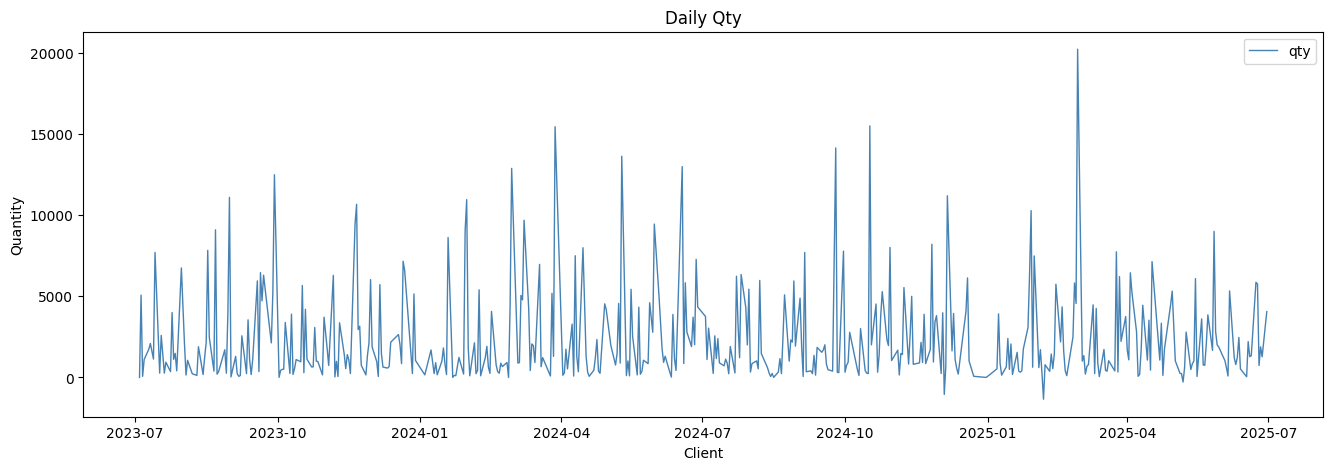

In [16]:
plt.figure(figsize=(16,5))
plt.plot(daily.qty,
         color='steelblue', linewidth=1,
         label="qty"
    )
plt.title("Daily Qty")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.show()

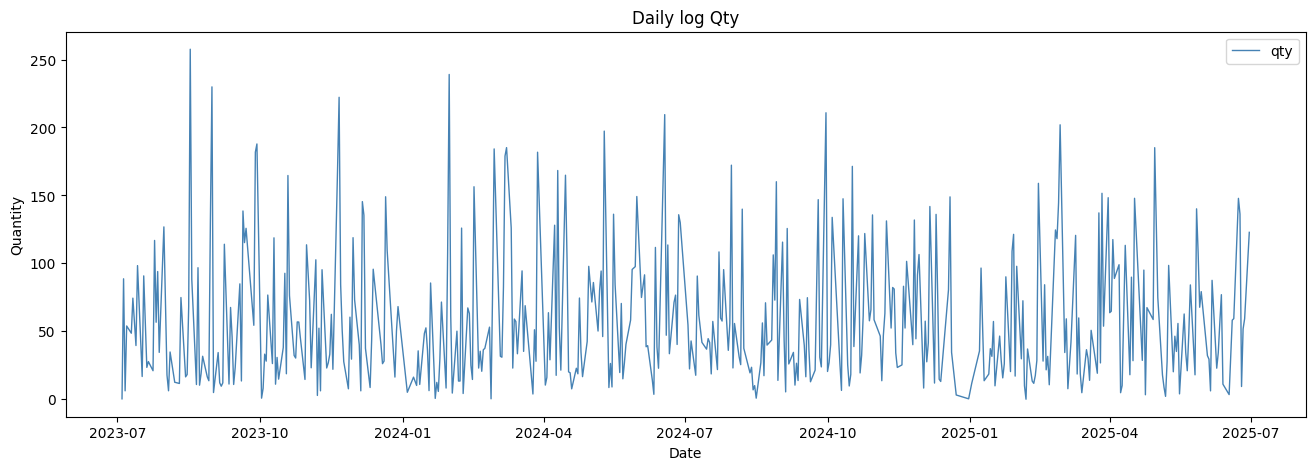

In [18]:
plt.figure(figsize=(16,5))
plt.plot(daily.qty_log,
         color='steelblue', linewidth=1,
         label="qty"
    )
plt.title("Daily log Qty")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.show()

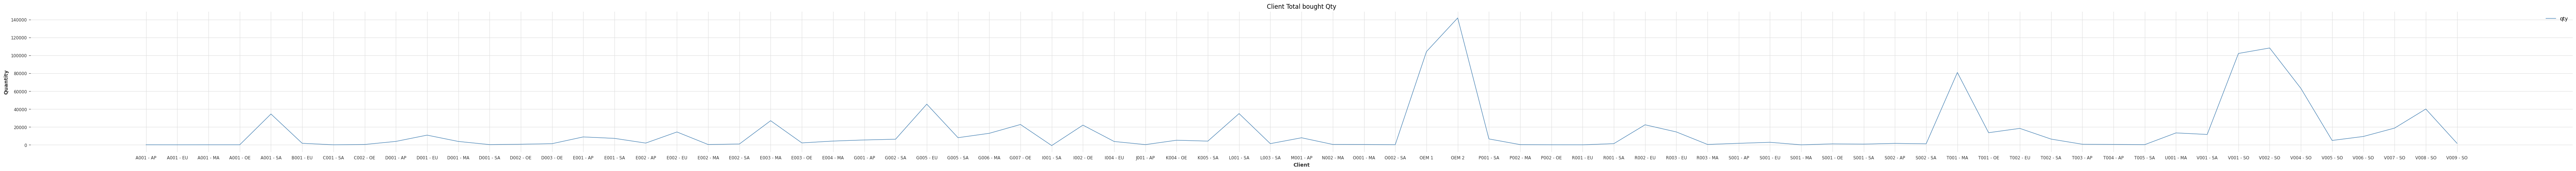

In [85]:
plt.figure(figsize=(90,5))
plt.plot(client_total_qty.qty,
         color='steelblue', linewidth=1,
         label="qty"
    )
plt.title("Client Total bought Qty")
plt.xlabel("Client")
plt.ylabel("Quantity")
plt.legend()
plt.show()

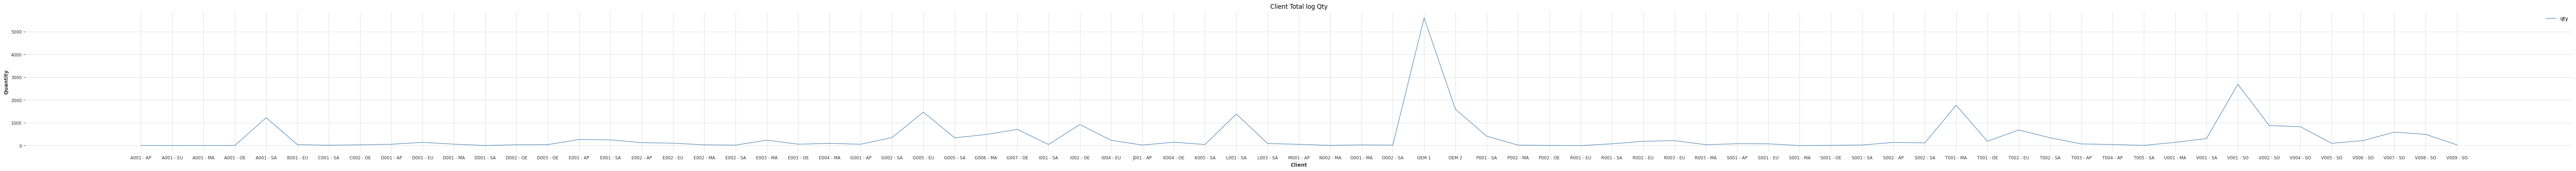

In [88]:
plt.figure(figsize=(90,5))
plt.plot(client_total_qty.qty_log,
         color='steelblue', linewidth=1,
         label="qty"
    )
plt.title("Client Total log Qty")
plt.xlabel("Client")
plt.ylabel("Quantity")
plt.legend()
plt.show()

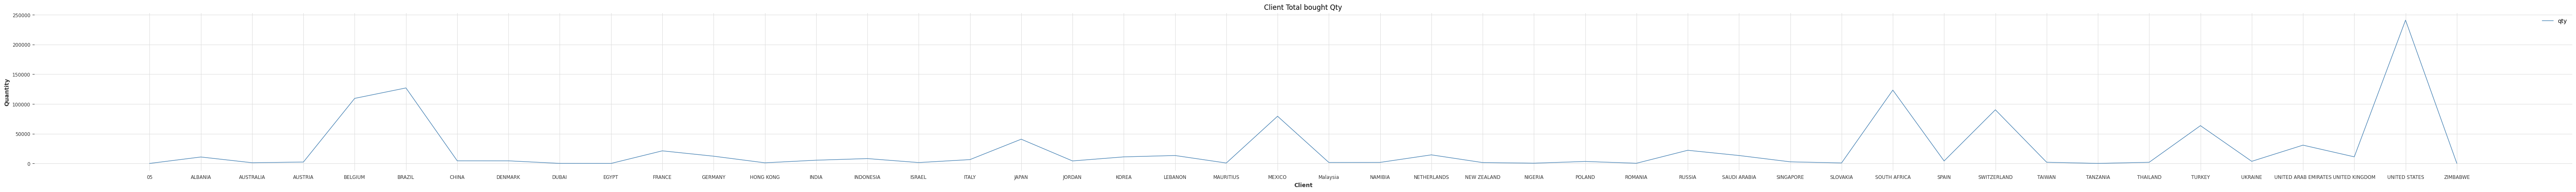

In [90]:
plt.figure(figsize=(80,5))
plt.plot(region_qty.qty,
         color='steelblue', linewidth=1,
         label="qty"
    )
plt.title("Client Total bought Qty")
plt.xlabel("Client")
plt.ylabel("Quantity")
plt.legend()
plt.show()



In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf
stat, p_value, lags, crit = kpss(daily.qty_sold, regression='c', nlags="auto")

def analyze_time_series(item, ts, freq='D', seasonal_period=None, plot=True):
    """
    Analyze a time series for stationarity and seasonality.

    Parameters:
        ts (pd.Series): Time series with datetime index.
        freq (str): Frequency of the series ('D', 'M', etc.)
        seasonal_period (int): Number of observations per seasonal cycle.
        plot (bool): Whether to plot ACF and decomposition.

    Returns:
        dict: Results of ADF and KPSS tests.
    """
    results = {}
    
    # Ensure numeric
    ts = ts.astype(float)
    
    # --- ADF test ---
    adf_result = adfuller(ts)
    results['ADF Statistic'] = adf_result[0]
    results['ADF p-value'] = adf_result[1]
    
    # --- KPSS test ---
    try:
        kpss_result = kpss(ts, regression='c', nlags="auto")
        results['KPSS Statistic'] = kpss_result[0]
        results['KPSS p-value'] = kpss_result[1]
    except:
        results['KPSS Statistic'] = np.nan
        results['KPSS p-value'] = np.nan
    
    # Interpretation
    results['ADF stationary'] = adf_result[1] <= 0.05
    results['KPSS stationary'] = kpss_result[1] > 0.05 if 'KPSS p-value' in results else np.nan
    
    # --- Optional plots ---  
    print (f"Stats for: {item}")
    print("ADF p-value:", adf_result[1], "| Stationary:" , results['ADF stationary'])
    print("KPSS p-value:", results.get('KPSS p-value'), "| Stationary:" , results.get('KPSS stationary'))
    if plot:

        
        # Plot ACF
        plt.figure(figsize=(10,4))
        plot_acf(ts, lags=30)
        plt.title(f"Autocorrelation (ACF) [{item}]")
        plt.show()
        
        # Decomposition
        if seasonal_period:
            decomp = seasonal_decompose(ts, model='additive', period=seasonal_period)
            decomp.plot()
            plt.show()
    
    return results

AttributeError: 'DataFrame' object has no attribute 'qty_sold'

In [92]:
deseasonal = daily.qty_sold - decomp.seasonal
plt.figure(figsize=(15,5))
plt.plot(daily.date, deseasonal,
         color='steelblue', linewidth=1
    )
plt.title("Daily Qty Sold (Deseasonal)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.show()
analyze_time_series("All", daily.qty_sold, seasonal_period=7, plot=True)

AttributeError: 'DataFrame' object has no attribute 'qty_sold'

In [93]:
daily_by_customer = df.groupby(['cust_id', 'date'], as_index=False)['qty'].sum()
daily_by_item = df.groupby(['color_container', 'date'], as_index=False)['qty'].sum()

/tmp/ipykernel_379483/2259998824.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_by_customer = df.groupby(['cust_id', 'date'], as_index=False)['qty'].sum()
/tmp/ipykernel_379483/2259998824.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_by_item = df.groupby(['color_container', 'date'], as_index=False)['qty'].sum()


In [94]:
daily_by_item

,color_container,date,qty
0,_Bottle 0.5L,2023-07-04,0
1,_Bottle 0.5L,2023-07-05,0
2,_Bottle 0.5L,2023-07-06,0
3,_Bottle 0.5L,2023-07-07,0
4,_Bottle 0.5L,2023-07-10,0
...,...,...,...
62505,Yellow_Pouch 500ml,2025-06-24,0
62506,Yellow_Pouch 500ml,2025-06-25,0
62507,Yellow_Pouch 500ml,2025-06-26,0
62508,Yellow_Pouch 500ml,2025-06-27,0


In [95]:
"""
mostly meaningless but just wanted some pattern insight
"""
# uniq_items = daily_by_item.color_container.unique()
# for i in uniq_items:
#     print("-"*100)
#     iframe = daily_by_item[daily_by_item.color_container == i]
#     print(iframe.qty)
#     plt.title(f"{i}")
#     plt.plot(iframe.date, iframe.qty)
#     plt.show()
#     r = analyze_time_series(i, iframe.qty, seasonal_period=7, plot=False)
#     print(r)

'\nmostly meaningless but just wanted some pattern insight\n'

In [ ]:
g = sns.FacetGrid(daily_by_customer, col="cust_id", col_wrap=4, height=3, sharey=False)
g.map_dataframe(sns.scatterplot, x="date", y="qty", s=20)
g.map_dataframe(sns.lineplot, x="date", y="qty")
g.set_titles("Customer {col_name}")
plt.show()


In [14]:
# Number of unique customers, specific items, actual item
df[["cust_id" ,"item", "color_container"]].nunique()

cust_id              75
item               1177
color_container     133
dtype: int64

In [19]:
def split_train_test(df, split_date):
    train = df[df['date'] < split_date].copy()
    test = df[df['date'] >= split_date].copy()
    return (train, test)

def target_feature_split(df, features, target):
    X, y = df[features], df[target]
    return (X, y)
    


Validation RMSE: 6801.30412


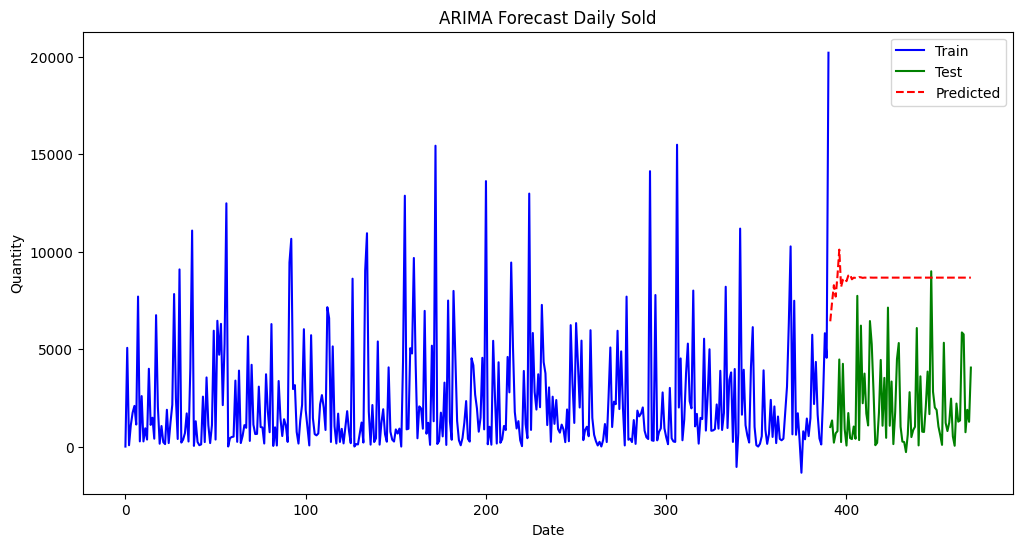

In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error

dailySold = (
    df.groupby(['date'])['qty']
      .sum()
      .reset_index()
)

trg = "qty"
atr, ats = split_train_test(dailySold,split_date)
atr, ats = atr[trg], ats[trg]

model = ARIMA(atr, order=(5,1,0))  # (p,d,q)
model_fit = model.fit()

# Forecast for test period

y_pred = model_fit.forecast(steps=len(ats))
y_true = ats.clip(0)
y_pred_clip = y_pred.clip(0)
rmse = root_mean_squared_error(ats, y_pred)
rmsle = root_mean_squared_log_error(y_true, y_pred_clip)

print(f"Validation RMSE: {rmse:.5f}")
plt.figure(figsize=(12,6))
plt.plot(atr.index, atr, label='Train', color='blue')
plt.plot(ats.index, ats, label='Test', color='green')
plt.plot(ats.index, y_pred, label='Predicted', color='red', linestyle='--')
plt.title('ARIMA Forecast Daily Sold')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

### BASELINE LightBGM

In [34]:
# =========================
# 🌿 Tiny LightGBM train
# =========================
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define split date
split_date = '2025-03-01'
target = "qty_soldR2_log"

basic_feats = ["cust_id","day", "month", "year", "currency", "region", "dayofweek", "dayofyear"]
train , test = split_train_test(df, split_date)
X_train, y_train = target_feature_split(train, basic_feats, target)
X_val, y_val = target_feature_split(test, basic_feats, target)

model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=32,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

cat_feats = ['cust_id', 'region', 'currency']
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_feats,
    callbacks=[]
    # early_stopping removed in some LightGBM builds; if available:
    # callbacks=[lightgbm.early_stopping(100), lightgbm.log_evaluation(100)]
)

# Evaluate (RMSLE)
y_val_pred = model.predict(X_val)
# rmsle = root_mean_squared_log_error(y_val, val_pred)
rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
# print(f"Validation RMSLE: {rmsle:.5f}")
print(f"Validation RMSE: {rmse:.5f}")
print(f"Validation MAE: {mae:.5f}")

y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Training RMSE: {rmse:.5f}")
print(f"Training MAE: {mae:.5f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 17964, number of used features: 8
[LightGBM] [Info] Start training from score 3.006521
Validation RMSE: 1.32216
Validation MAE: 1.04292
Training RMSE: 0.89172
Training MAE: 0.68823


In [ ]:
import numpy as np
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor



def lgb_obj_function(params):
    """
    PSO objective function to minimize RMSE
    params: ndarray of shape (n_particles, n_dimensions)
    """
    n_particles = params.shape[0]
    rmse_values = np.zeros(n_particles)
    
    for i in range(n_particles):
        # extract parameters
        num_leaves = int(params[i, 0])
        max_depth = int(params[i, 1])
        learning_rate = params[i, 2]
        min_child_samples = int(params[i, 3])
        subsample = params[i, 4]
        colsample_bytree = params[i, 5]
        
        # train model
        model = LGBMRegressor(
            n_estimators=500,
            num_leaves=num_leaves,
            max_depth=max_depth,
            learning_rate=learning_rate,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
            verbose=-1
        )
        
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        y_pred = model.predict(X_val)
        rmse_values[i] = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse_values

    


# bounds: lower and upper for each hyperparameter
lb = [20, 3, 0.001, 5, 0.5, 0.5]  # lower bounds
ub = [150, 12, 0.2, 50, 1.0, 1.0]  # upper bounds

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

optimizer = GlobalBestPSO(
    n_particles=10,   # increase for more exploration
    dimensions=len(lb),     # number of hyperparameters
    options=options,
    bounds=(lb, ub)
)


best_cost, best_pos = optimizer.optimize(lgb_obj_function, iters=20)

print("Best RMSE:", best_cost)
print("Best hyperparameters:", best_pos)



In [28]:
import matplotlib.pyplot as plt

# Example variables
# y_train: training target values
# y_val: validation target values
# y_pred: model predictions on validation set
def plot_target(y_val, y_pred):
    plt.figure(figsize=(12, 6))
    
    y_val = np.array(y_val)
    y_pred = np.array(y_pred)
    
    # Plot validation target
    plt.plot(np.arange(len(y_val)), y_val, label="y_val", color="green")
    
    # Plot predictions
    plt.plot(np.arange(len(y_pred)), y_pred, label="y_pred", color="red", linestyle="--")
    
    plt.xlabel("Time / Index")
    plt.ylabel("Quantity")
    plt.title("Validation vs Predictions")
    plt.legend()
    plt.show()


In [110]:
y_pred.describe()

count     118.000000
mean     1429.528896
std        89.435843
min      1157.303053
25%      1422.004832
50%      1422.004833
75%      1422.004857
max      2103.695537
Name: predicted_mean, dtype: float64

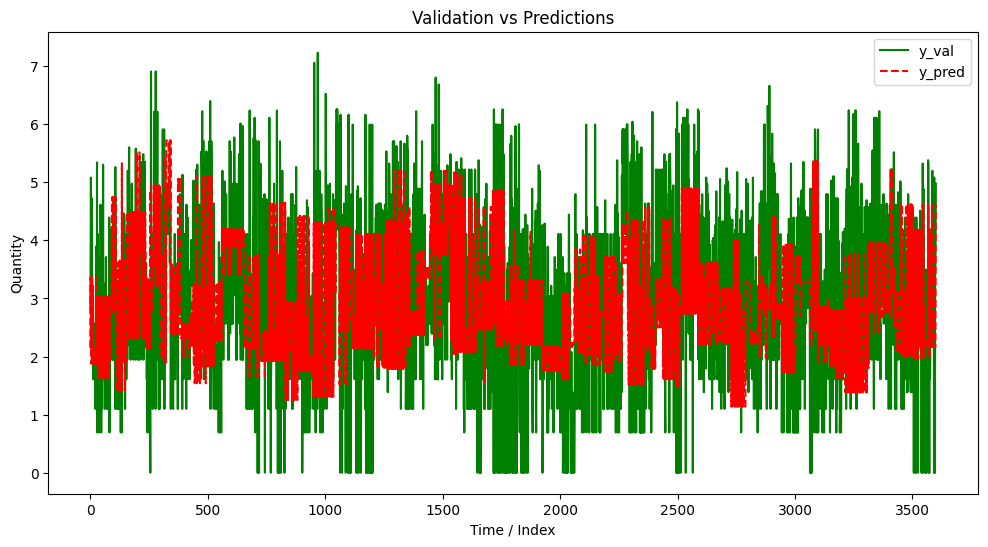

In [35]:
plot_target(y_val, y_val_pred)

In [36]:
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np


def train_model(train, val, cat_feats, params):
    model = LGBMRegressor(
    n_estimators=2000,
    learning_rate = params["lr"],
    max_depth = math.ceil(params["max_depth"]),
    num_leaves= math.ceil(params["num_leaves"]),
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose = -1
    )

    model.fit(
    train["X"], train["y"],
    eval_set=[(val["X"], val["y"])],
    eval_metric="rmse",
    categorical_feature=cat_feats,
    callbacks=[]
    )

    return model

def evaluate_model(model, X_val, y_val):
    val_pred = model.predict(X_val)
    # rmsle = root_mean_squared_log_error(y_val, val_pred)
    rmse = root_mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    # print(f"Validation RMSLE: {rmsle:.5f}")
    print(f"Validation RMSE: {rmse:.5f}")
    print(f"Validation MAE: {mae:.5f}")
    return val_pred

In [113]:
model = LGBMRegressor(
    n_estimators=2000,
    learning_rate = best_params[2],
    max_depth = math.ceil(best_params[1]),
    num_leaves= math.ceil(best_params[0]),
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

cat_feats = basic_feats
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_feats,
    callbacks=[]
    # early_stopping removed in some LightGBM builds; if available:
    # callbacks=[lightgbm.early_stopping(100), lightgbm.log_evaluation(100)]
)

# Evaluate (RMSLE)
val_pred = np.clip(model.predict(X_val), 0, None)
rmse = root_mean_squared_error(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
print(f"Validation MAE: {mae:.5f}")
print(f"Validation RMSE: {rmse:.5f}")


NameError: name 'best_params' is not defined

In [114]:
df.columns

Index(['date', 'cust_id', 'region', 'item', 'qty', 'price', 'netsales',
       'currency', 'color', 'container', 'color_container', 'dayofweek',
       'month', 'dayofyear', 'day', 'year', 'client_item_id', 'quarter',
       'is_year_start', 'is_year_end', 'is_month_start', 'is_month_end',
       'qty_sold', 'qty_returned', 'qty_log'],
      dtype='object')

### More Feature engineering

In [37]:
#create lags and rolling
target = "qty_sold"
lags = [1, 7, 14, 30]
for lag_i in lags:
    df[f"{target}_lag{lag_i}"] =  df.groupby(["date", "cust_id", "item"])[target].shift(lag_i).fillna(0)
lag_feats = [ f"{target}_lag{i}" for i in lags]

# Example: 2-day rolling mean for each client-item pair

for i in [3, 7, 14, 60]:
    df[f"rolling_mean_{i}"] = (
        df.groupby(["cust_id", "item"])[target]
          .rolling(window=i, min_periods=1)
          .mean()
          .reset_index(level=[0,1], drop=True)
    )
    lag_feats.append(f"rolling_mean_{i}")
    df[f"rolling_std_{i}"] = (
        df.groupby(["cust_id", "item"])[target]
          .rolling(window=i, min_periods=1)
          .std()
          .reset_index(level=[0,1], drop=True)
    )
    
    lag_feats.append(f"rolling_std_{i}")

df["days_since_client_purchase"] =  df.groupby("cust_id")["date"].diff().dt.days
lag_feats.append("days_since_client_purchase")
df["days_since_client_item_purchase"] =  df.groupby(["cust_id", "item"])["date"].diff().dt.days
lag_feats.append("days_since_client_item_purchase")

/tmp/ipykernel_276239/4281092292.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f"{target}_lag{lag_i}"] =  df.groupby(["date", "cust_id", "item"])[target].shift(lag_i).fillna(0)
/tmp/ipykernel_276239/4281092292.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f"{target}_lag{lag_i}"] =  df.groupby(["date", "cust_id", "item"])[target].shift(lag_i).fillna(0)
/tmp/ipykernel_276239/4281092292.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future def

In [38]:
df.to_csv("full_df.csv", index=False)

In [280]:
# df["series_id"] = (df["cust_id"].astype(str) + "_" + df["item"].astype(str)).astype("category")
cat_feats = ["cust_id",  "item", "currency"]
basic_feats = ["cust_id", "item", "price" , "currency"]
time_feats = ["day", "month","dayofweek","dayofyear", "quarter", "year"]

In [281]:

train , test = split_train_test(df, split_date)

In [282]:
train["item_qty_avg"] = train.groupby("item")[target].transform("mean").astype(np.float32)
train["cust_qty_avg"] = train.groupby("cust_id")[target].transform("mean").astype(np.float32)
train["cust_item_qty_avg"] = train.groupby(["cust_id", "item"])[target].transform("mean").astype(np.float32)
# Create mapping from category -> mean
item_mean_map = train.groupby("item")[target].mean()
cust_mean_map = train.groupby("cust_id")[target].mean()
cust_item_mean_map = train.groupby(["cust_id","item"])[target].mean()
test["item_qty_avg"] = test["item"].map(item_mean_map)
test["cust_qty_avg"] = test["cust_id"].map(cust_mean_map)
test["cust_item_qty_avg"] = test.set_index(["cust_id","item"]).index.map(cust_item_mean_map)
feats = basic_feats + time_feats + lag_feats  + ['item_qty_avg', 'cust_qty_avg', 'cust_item_qty_avg'] 

/tmp/ipykernel_276239/1940054020.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train["item_qty_avg"] = train.groupby("item")[target].transform("mean").astype(np.float32)
/tmp/ipykernel_276239/1940054020.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train["cust_qty_avg"] = train.groupby("cust_id")[target].transform("mean").astype(np.float32)
/tmp/ipykernel_276239/1940054020.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 

In [283]:
train["price"] = np.log(train["price"])
test["price"] = np.log(test["price"])

/mnt/generalNVME/projects/AI/ITMDA-Assignment_Predictive-Inventory-System/forecast/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [284]:
train.columns

Index(['date', 'cust_id', 'region', 'item', 'qty', 'price', 'netsales',
       'currency', 'color', 'container', 'color_container', 'dayofweek',
       'month', 'dayofyear', 'day', 'year', 'client_item_id', 'quarter',
       'is_year_start', 'is_year_end', 'is_month_start', 'is_month_end',
       'qty_sold', 'qty_soldR2', 'qty_returned', 'qty_log', 'qty_sold_log',
       'qty_soldR2_log', 'qty_sold_lag1', 'qty_sold_lag7', 'qty_sold_lag14',
       'qty_sold_lag30', 'rolling_mean_3', 'rolling_std_3', 'rolling_mean_7',
       'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_60',
       'rolling_std_60', 'days_since_client_purchase',
       'days_since_client_item_purchase', 'category_qty',
       'category_mean_price', 'series_id', 'item_qty_avg', 'cust_qty_avg',
       'cust_item_qty_avg'],
      dtype='object')

In [285]:
lag_feats

['qty_sold_lag1',
 'qty_sold_lag7',
 'qty_sold_lag14',
 'qty_sold_lag30',
 'rolling_mean_3',
 'rolling_std_3',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_mean_14',
 'rolling_std_14',
 'rolling_mean_60',
 'rolling_std_60',
 'days_since_client_purchase',
 'days_since_client_item_purchase']

In [236]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with any NaN (also removes original NaNs)
train = train.dropna()
test = test.dropna()

In [145]:
X_train.columns

Index(['cust_id', 'item', 'price', 'currency', 'day', 'month', 'dayofweek',
       'dayofyear', 'quarter', 'year', 'qty_sold_lag1', 'qty_sold_lag7',
       'qty_sold_lag14', 'qty_sold_lag30', 'rolling_mean_3', 'rolling_std_3',
       'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14',
       'rolling_mean_60', 'rolling_std_60', 'days_since_client_purchase',
       'days_since_client_item_purchase'],
      dtype='object')

In [104]:
df["category_mean_price"] = df.groupby(["cust_id", "color_container", "date"])["price"].transform("mean")
    

/tmp/ipykernel_276239/2667002712.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["category_qty"] = df.groupby(["cust_id", "color_container", "date"])["qty"].transform("sum")
/tmp/ipykernel_276239/2667002712.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["category_mean_price"] = df.groupby(["cust_id", "color_container", "date"])["price"].transform("mean")


In [126]:
df

,date,cust_id,region,item,qty,price,netsales,currency,color,container,...,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_60,rolling_std_60,days_since_client_purchase,days_since_client_item_purchase,category_qty,category_mean_price
0,2023-07-04,L001 - SA,SOUTH AFRICA,4750828,2,1800,3600,R,Magenta,Bottle 5L,...,3.000000,NaN,3.000000,NaN,3.000000,NaN,NaN,NaN,2,1800.0
39,2023-07-05,V002 - SO,BRAZIL,4750228,300,300,90000,USD,Magenta,Pouch 1000ml,...,301.000000,NaN,301.000000,NaN,301.000000,NaN,NaN,NaN,300,300.0
59,2023-07-05,V007 - SO,BRAZIL,4750667,30,400,12000,USD,Clear,Bottle 1L,...,31.000000,NaN,31.000000,NaN,31.000000,NaN,NaN,NaN,60,300.0
49,2023-07-05,V007 - SO,BRAZIL,4750617,90,300,27000,USD,Magenta,Bottle 1L,...,91.000000,NaN,91.000000,NaN,91.000000,NaN,0.0,NaN,132,350.0
31,2023-07-05,V002 - SO,BRAZIL,4750096,30,600,18000,USD,Black,Bottle 5L,...,31.000000,NaN,31.000000,NaN,31.000000,NaN,0.0,NaN,30,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21559,2025-06-30,L001 - SA,SOUTH AFRICA,4750199,-2,400,-800,R,Yellow,Cartridge 500ml,...,90.142857,74.965389,107.285714,123.713956,105.000000,111.879635,0.0,0.0,206,400.0
21523,2025-06-30,L001 - SA,SOUTH AFRICA,4750200,32,400,12800,R,Black,Cartridge 500ml,...,26.142857,20.358688,47.857143,54.877286,54.818182,61.976675,0.0,0.0,95,400.0
21533,2025-06-30,L001 - SA,SOUTH AFRICA,4750211,32,400,12800,R,Magenta,Cartridge 500ml,...,26.285714,28.860089,33.071429,23.378045,30.235294,21.998663,0.0,0.0,269,400.0
21516,2025-06-30,V001 - SA,SOUTH AFRICA,4750342,60,300,18000,R,Black,Bottle 1L,...,71.285714,27.213442,69.571429,22.290786,69.000000,21.593650,0.0,69.0,60,300.0


In [146]:
feats

['cust_id',
 'item',
 'price',
 'currency',
 'day',
 'month',
 'dayofweek',
 'dayofyear',
 'quarter',
 'year',
 'qty_sold_lag1',
 'qty_sold_lag7',
 'qty_sold_lag14',
 'qty_sold_lag30',
 'rolling_mean_3',
 'rolling_std_3',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_mean_14',
 'rolling_std_14',
 'rolling_mean_60',
 'rolling_std_60',
 'days_since_client_purchase',
 'days_since_client_item_purchase']

In [106]:
# feats.append('category_mean_price')

In [286]:
# train, test = train[train.qty_sold < 100], test[test.qty_sold < 100]
# feats.append("region")
split_date = '2025-03-01'
target = "qty_sold"
# train , test = split_train_test(df, split_date)
X_train, y_train = target_feature_split(train, feats, target)
X_val, y_val = target_feature_split(test, feats, target)
params = {
    "lr":0.001,
    "max_depth": 8,
    "num_leaves": 64
}
train_param = {
    "X": X_train,
    "y": y_train,
}

val_param = {
    "X": X_val,
    "y": y_val,
}


# preds = pd.DataFrame()
# for q in quantiles:
#     preds[f"q{int(q*100)}"] = models[q].predict(X_val)
# y_pred = preds["q50"].values
model = train_model(train_param, val_param, cat_feats, params)
y_val_pred = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation RMSE: {rmse:.5f}")
print(f"Validation MAE: {mae:.5f}")
print(f"Val R2: {r2_score(y_val, y_val_pred):.5f}")
y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Training RMSE: {rmse:.5f}")
print(f"Training MAE: {mae:.5f}")
print(f"Training R2: {r2_score(y_train, y_train_pred):.5f}")

# preds["pred_std"] = preds["q90"] - preds["q10"]
# print(preds[["q10", "q50", "q90", "pred_std"]].head())


Validation RMSE: 46.28683
Validation MAE: 21.93634
Val R2: 0.73337
Training RMSE: 42.73393
Training MAE: 18.57091
Training R2: 0.85343


In [243]:
y_actual_pred = y_val_pred if target == "qty_sold" else np.exp(y_val_pred)
y_actual = test["qty_sold"]

In [226]:
resid_train = y_train - y_train_pred
resid_val = y_val - y_val_pred


In [244]:
resid_train = y_train - y_train_pred
resid_val = y_actual - y_actual_pred


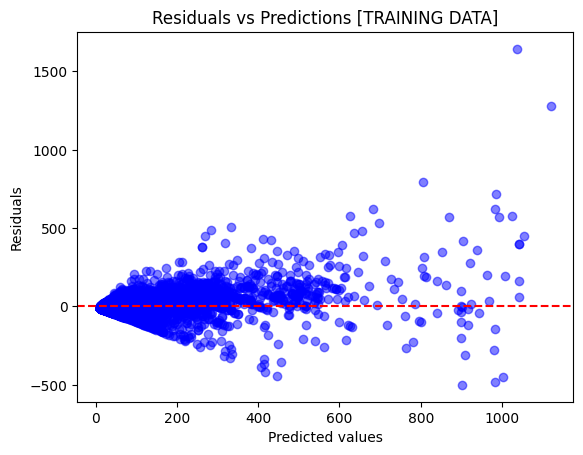

In [245]:
import matplotlib.pyplot as plt

plt.scatter(y_train_pred, resid_train, alpha=0.5, c='blue')
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions [TRAINING DATA]")
plt.show()


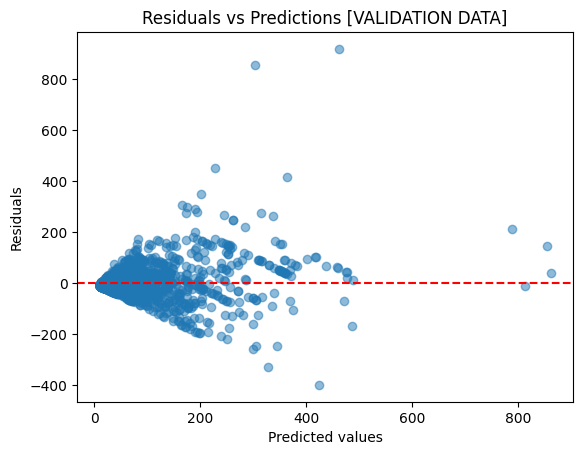

In [246]:
import matplotlib.pyplot as plt

plt.scatter(y_actual_pred, resid_val, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions [VALIDATION DATA]")
plt.show()


In [247]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import numpy as np

print("TRAINING Heteroscedasticity TEST")
exog = sm.add_constant(y_train_pred)  
bp_test = het_breuschpagan(resid_train, exog)
print("Breusch–Pagan p-value:", bp_test[1])

white_test = het_white(resid_train, exog)
print("White test p-value:", white_test[1])
print("-"*10)
print("VALIDATION Heteroscedasticity TEST")
exog = sm.add_constant(y_val_pred)  
bp_test = het_breuschpagan(resid_val, exog)
print("Breusch–Pagan p-value:", bp_test[1])

white_test = het_white(resid_val, exog)
print("White test p-value:", white_test[1])

TRAINING Heteroscedasticity TEST
Breusch–Pagan p-value: 0.0
White test p-value: 0.0
----------
VALIDATION Heteroscedasticity TEST
Breusch–Pagan p-value: 2.23216748023289e-66
White test p-value: 1.2487881531968768e-65


In [256]:
resid_val

17981    -2.299001
17978    -0.215788
17986    96.696719
17982    42.630128
17965   -13.622208
           ...    
21559   -24.409931
21523     3.327477
21533     0.242712
21516    -3.622458
21487    13.477147
Name: qty_sold, Length: 3601, dtype: float64

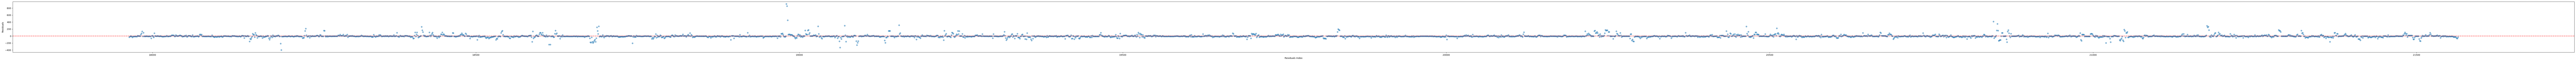

In [255]:
plt.figure(figsize=(200,4))
plt.scatter(resid_val.index, resid_val, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Residuals Index")
plt.ylabel("Residuals")
# plt.title("Residuals vs Predictions [VALIDATION DATA]")
plt.show()

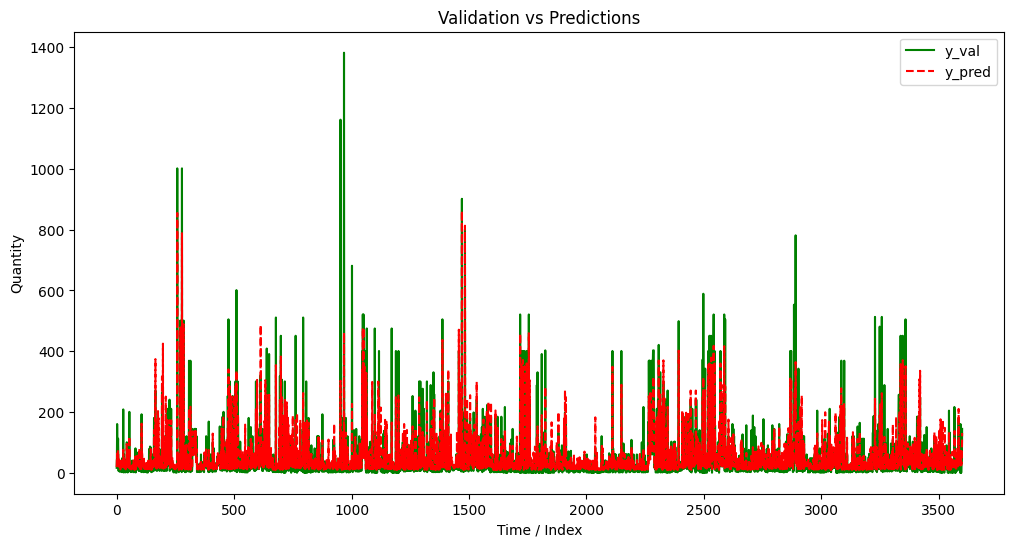

In [248]:
plot_target(y_val, y_val_pred)

In [58]:
df.qty_sold.describe()

count    21565.000000
mean        52.763227
std        108.278386
min          1.000000
25%          7.000000
50%         19.000000
75%         51.000000
max       2681.000000
Name: qty_sold, dtype: float64

In [246]:
df.color_container.cat.codes

0         90
52        68
39        96
59        19
49        85
        ... 
21559    126
21523     11
21486     19
21513    117
21487      2
Length: 21565, dtype: int16

In [247]:
pd.Series(resid_val).describe()

count    3235.000000
mean       -1.821507
std        45.195942
min      -350.912255
25%       -13.331968
50%        -6.852511
75%         3.044924
max       862.905869
Name: qty_sold, dtype: float64

In [194]:
# y_val_pred = np.sqrt(y_val_pred)
# y_val = test["qty_sold"]

In [249]:
# trainR2_residuals = resid_train
# valR2_residuals = resid_val
                
trainR2_residuals = resid_train
valR2_residuals = resid_val
params = {
    "lr":0.001,
    "max_depth": 8,
    "num_leaves": 64
}
train_param = {
    "X": X_train,
    "y": trainR2_residuals,
}

eval_param = {
    "X": X_val,
    "y": valR2_residuals,
}

model = train_model(train_param, eval_param, cat_feats, params)
pred_residuals = model.predict(X_val)
rmse = root_mean_squared_error(valR2_residuals, pred_residuals)
mae = mean_absolute_error(valR2_residuals, pred_residuals)
print(f"Residual RMSE: {rmse:.5f}")
print(f"Residual MAE: {mae:.5f}")
# pred_residuals = pred_residuals
# pred_residuals_com = y_val_pred + pred_residuals 
# rmse = root_mean_squared_error(y_val, pred_residuals_com)
# mae = mean_absolute_error(y_val, pred_residuals_com)
# print(f"Combined RMSE: {rmse:.5f}")
# print(f"Combined MAE: {mae:.5f}")

Residual RMSE: 45.42419
Residual MAE: 20.01583


In [241]:

predictions = pd.DataFrame({
    "client": test['cust_id'],
    "item": test['item'],
    "y_val": y_actual,
    "y_pred": y_actual_pred,
    "actual_resid": resid_val,
    "resid_pred": pred_residuals,
    "final_upper": y_val_pred + pred_residuals,  
    "final_lower": y_val_pred - pred_residuals  
})
predictions["within actual"] = y_val.between(predictions["final_lower"], predictions["final_upper"])
predictions.to_csv("predictions.csv", index=False)
predictions

,client,item,y_val,y_pred,actual_resid,resid_pred,final_upper,final_lower,within actual
17981,T002 - SA,4750381,17,19.299001,7.574880,-0.183923,19.115078,19.482925,False
17978,G005 - SA,4751111,49,49.215788,7.379216,0.146159,49.361947,49.069630,False
17986,T002 - SA,4750199,161,64.303281,127.812764,-0.172025,64.131256,64.475305,False
17982,T002 - SA,4750200,81,38.369872,62.676003,-0.253967,38.115905,38.623839,False
17965,OEM 1,4750653,25,38.622208,-4.998230,0.077693,38.699900,38.544515,False
...,...,...,...,...,...,...,...,...,...
21559,L001 - SA,4750199,1,25.409931,-8.607129,-0.519562,24.890369,25.929493,False
21523,L001 - SA,4750200,33,29.672523,15.381062,-0.064798,29.607726,29.737321,False
21533,L001 - SA,4750211,33,32.757288,14.450509,-0.121619,32.635670,32.878907,False
21516,V001 - SA,4750342,61,64.622458,6.297163,0.141072,64.763531,64.481386,False


In [159]:
predictions["within actual"].value_counts()

within actual
False    3313
True      288
Name: count, dtype: int64

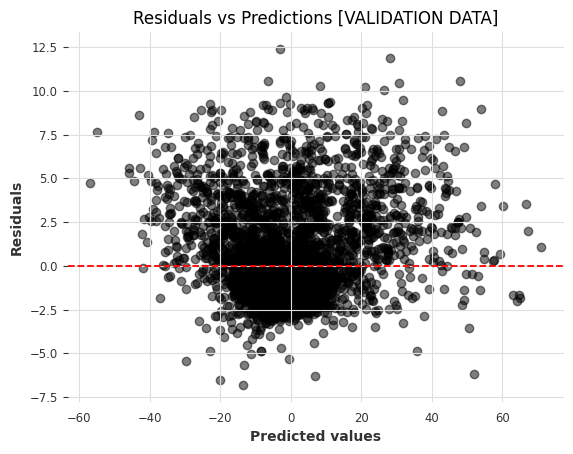

In [185]:
import matplotlib.pyplot as plt

plt.scatter(resid_val, pred_residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions [VALIDATION DATA]")
plt.show()

In [266]:
df["series_id"] = df["cust_id"].astype(str) + "_" + df["item"].astype(str) + "_" + df["date"].astype(str)

In [268]:
import pandas as pd
from sklearn.ensemble import IsolationForest

data = df["qty_sold"]

X = data.to_frame(name="qty_sold")
# Fit Isolation Forest
clf = IsolationForest(contamination=0.15, random_state=42)  # contamination = expected % outliers
clf.fit(X)

# Predict
outlier_s = clf.predict(X)  # -1 = outlier, 1 = normal
s_scores = clf.decision_function(X)  # anomaly score

outliers = pd.DataFrame({
    "series_id": df["series_id"],
    "qty_sold": data,
    "outlier_flag": outlier_s,
    "score": s_scores
})
outliers.to_csv("outliers.csv")